# Human vs Model UX Assessment Comparison

This notebook compares human evaluations with model evaluations for dark patterns, focusing on UX KPI metrics and pattern assessments.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import os

# Set up visual style
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")

# Create output directory
output_dir = "comparison_output"
os.makedirs(output_dir, exist_ok=True)

## Load Data

First, let's load both human evaluations and model evaluations.

In [2]:
# Load human data
human_data = pd.read_csv("Formatting Human Survey Data/raw_participant_evaluations.csv")

# Fix column name for consistency
if 'score_addictive_non-addictive' in human_data.columns:
    human_data = human_data.rename(columns={'score_addictive_non-addictive': 'score_addictive_non_addictive'})

# Add data source column
human_data['data_source'] = 'Human'

print(f"Human data shape: {human_data.shape}")
human_data.head()

Human data shape: (348, 19)


,metadata_participant_id,metadata_timestamp,metadata_pattern_type,metadata_interface_id,score_inefficient_efficient,score_interesting_not_interesting,score_clear_confusing,score_enjoyable_annoying,score_organized_cluttered,score_addictive_non_addictive,score_supportive_obstructive,score_pressuring_suggesting,score_boring_exciting,score_revealed_covert,score_complicated_easy,score_unpredictable_predictable,score_friendly_unfriendly,score_deceptive_benevolent,data_source
0,P002,2025-04-04T10:06:23,Overcomplicated Process,interface_002,6,5,3,2,6,4,6,6,4,5,5,3,3,5,Human
1,P002,2025-04-04T10:06:25,Sneaking Bad Default,interface_004,3,4,4,1,6,3,4,5,3,3,6,4,1,4,Human
2,P002,2025-04-04T10:06:29,Toying With Emotion,interface_008,2,6,7,3,4,7,5,2,6,2,6,1,3,4,Human
3,P002,2025-04-04T10:06:35,Endlessness,interface_014,5,2,5,1,6,4,3,4,7,2,5,4,2,3,Human
4,P003,2025-04-04T10:06:26,Expectation Result Mismatch,interface_005,4,4,4,4,6,4,4,4,1,4,3,4,2,4,Human


In [3]:
# Load model data (combining all model results)
model_files = [
    "model_analysis_test/results_anthropic_opus_neutral_description.csv",
    "model_analysis_test/results_ollama_gemma3.csv",
    "model_analysis_test/results_openai_gpt4-vision-neutral.csv",
    "model_analysis_test/results_qwen-vl-max.csv"
]

model_data_list = []
for file in model_files:
    try:
        # First try normal loading
        df = pd.read_csv(file)
        # Check if first row contains statistical headers
        if any(col in str(df.iloc[0]).lower() for col in ['mean', 'std', 'min', 'max']):
            print(f"File {file} has statistical headers, skipping first row")
            df = pd.read_csv(file, skiprows=1)
        model_data_list.append(df)
    except Exception as e:
        print(f"Error reading {file}: {e}")

# Combine all model data
model_data = pd.concat(model_data_list, ignore_index=True)

# Fix column name for consistency
if 'score_addictive_non-addictive' in model_data.columns:
    model_data = model_data.rename(columns={'score_addictive_non-addictive': 'score_addictive_non_addictive'})

# Add data source column
model_data['data_source'] = 'AI Model'

print(f"Model data shape: {model_data.shape}")
model_data.head()

File model_analysis_test/results_qwen-vl-max.csv has statistical headers, skipping first row
Model data shape: (59, 44)


,metadata_timestamp,metadata_ai_service,metadata_model,metadata_pattern_type,metadata_interface_id,score_inefficient_efficient,score_interesting_not_interesting,score_clear_confusing,score_enjoyable_annoying,score_organized_cluttered,...,6.1,7,3.2,2.1,4.1,5.1,6.2,6.3,"The popup is perceived as inefficient and obstructive due to its repetitive nature. It is also seen as pressuring rather than suggesting, making it unfriendly and annoying. The feature is not particularly interesting or exciting, and it is somewhat confusing and complicated.",data_source
0,2025-04-01T15:35:41.758887,anthropic,claude-3-opus-20240229,Nagging,interface_001,2.0,6.0,2.0,6.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AI Model
1,2025-04-01T15:35:52.881322,anthropic,claude-3-opus-20240229,Overcomplicated Process,interface_002,2.0,6.0,6.0,6.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AI Model
2,2025-04-01T15:36:04.711931,anthropic,claude-3-opus-20240229,Hindering Account Deletion,interface_003,2.0,6.0,2.0,6.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AI Model
3,2025-04-01T15:36:16.000749,anthropic,claude-3-opus-20240229,Sneaking Bad Default,interface_004,7.0,3.0,3.0,3.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AI Model
4,2025-04-01T15:36:27.400215,anthropic,claude-3-opus-20240229,Expectation Result Mismatch,interface_005,2.0,5.0,6.0,6.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AI Model


## Calculate UX KPI

Calculate the UX KPI for both human and model assessments based on negative UX aspects.

In [4]:
def calculate_ux_kpi(df):
    """Calculate UX KPI based on negative UX aspects."""
    # Create a copy to avoid modifying the input
    result_df = df.copy()
    
    # Define UX KPI components
    ux_kpi_items = {
        'boring': 'score_boring_exciting',           # Low = boring
        'not_interesting': 'score_interesting_not_interesting',  # High = not interesting
        'complicated': 'score_complicated_easy',     # Low = complicated
        'confusing': 'score_clear_confusing',        # High = confusing
        'inefficient': 'score_inefficient_efficient', # Low = inefficient
        'cluttered': 'score_organized_cluttered',     # High = cluttered
        'unpredictable': 'score_unpredictable_predictable', # Low = unpredictable
        'obstructive': 'score_supportive_obstructive'  # High = obstructive
    }
    
    # Create columns with standardized values (higher = worse UX)
    for ux_item, column in ux_kpi_items.items():
        if column in result_df.columns:
            if ux_item in ['not_interesting', 'confusing', 'cluttered', 'obstructive']:
                # These are already oriented so high values = negative aspect
                result_df[f'ux_{ux_item}'] = result_df[column]
            else:
                # Invert these so high values = negative aspect
                result_df[f'ux_{ux_item}'] = 8 - result_df[column]  # 8 - value (1-7 scale)
    
    # Calculate UX KPI (mean of all items)
    ux_items = [f'ux_{item}' for item in ux_kpi_items.keys() if f'ux_{item}' in result_df.columns]
    
    if ux_items:
        result_df['ux_kpi'] = result_df[ux_items].mean(axis=1)
        
        # Also determine worst aspect for each row
        result_df['worst_aspect'] = result_df[ux_items].idxmax(axis=1).str.replace('ux_', '')
        result_df['worst_value'] = result_df[ux_items].max(axis=1)
    
    return result_df

# Calculate UX KPI for human data
human_data_with_kpi = calculate_ux_kpi(human_data)

# Calculate UX KPI for model data
model_data_with_kpi = calculate_ux_kpi(model_data)

# Show sample results
print("Human Data with UX KPI:")
print(human_data_with_kpi[['metadata_pattern_type', 'ux_kpi', 'worst_aspect', 'worst_value']].head())

print("\nModel Data with UX KPI:")
print(model_data_with_kpi[['metadata_pattern_type', 'metadata_ai_service', 'metadata_model', 'ux_kpi', 'worst_aspect', 'worst_value']].head())

Human Data with UX KPI:
         metadata_pattern_type  ux_kpi worst_aspect  worst_value
0      Overcomplicated Process   4.250    cluttered            6
1         Sneaking Bad Default   4.250    cluttered            6
2          Toying With Emotion   4.875    confusing            7
3                  Endlessness   3.375    cluttered            6
4  Expectation Result Mismatch   4.750       boring            7

Model Data with UX KPI:
         metadata_pattern_type metadata_ai_service          metadata_model  \
0                      Nagging           anthropic  claude-3-opus-20240229   
1      Overcomplicated Process           anthropic  claude-3-opus-20240229   
2   Hindering Account Deletion           anthropic  claude-3-opus-20240229   
3         Sneaking Bad Default           anthropic  claude-3-opus-20240229   
4  Expectation Result Mismatch           anthropic  claude-3-opus-20240229   

   ux_kpi     worst_aspect  worst_value  
0   4.250      obstructive          7.0  
1   6.00

/var/folders/66/73cb2jcd6jg68q_rlbh1rhzw0000gp/T/ipykernel_91692/3694105232.py:35: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  result_df['worst_aspect'] = result_df[ux_items].idxmax(axis=1).str.replace('ux_', '')


## Compare Human and Model Assessments

Now let's generate a comparison of the average UX KPI for each pattern type between humans and models.

In [5]:
# Calculate average UX KPI for each pattern type - Human data
human_pattern_kpi = human_data_with_kpi.groupby('metadata_pattern_type')['ux_kpi'].mean().reset_index()
human_pattern_kpi = human_pattern_kpi.rename(columns={'ux_kpi': 'human_ux_kpi'})

# Fix the "Pull to Refresh" and "Pull To Refresh" inconsistency
human_pattern_kpi['metadata_pattern_type'] = human_pattern_kpi['metadata_pattern_type'].replace('Pull to Refresh', 'Pull To Refresh')

# Calculate average UX KPI for each pattern type and model
model_pattern_kpi = model_data_with_kpi.groupby(['metadata_pattern_type', 'metadata_ai_service', 'metadata_model'])['ux_kpi'].mean().reset_index()
# Fix pattern names in model data
model_pattern_kpi['metadata_pattern_type'] = model_pattern_kpi['metadata_pattern_type'].replace('Pull to Refresh', 'Pull To Refresh')

# Create separate columns for each model
model_comparison_data = human_pattern_kpi.copy()

# Add each model's data as a separate column
for service in model_data_with_kpi['metadata_ai_service'].unique():
    for model in model_data_with_kpi[model_data_with_kpi['metadata_ai_service'] == service]['metadata_model'].unique():
        # Filter for this service/model
        filter_mask = (model_pattern_kpi['metadata_ai_service'] == service) & (model_pattern_kpi['metadata_model'] == model)
        model_data_subset = model_pattern_kpi[filter_mask]
        
        # Rename column and merge
        model_data_subset = model_data_subset.rename(columns={'ux_kpi': f'{service}_{model}'})
        model_comparison_data = model_comparison_data.merge(
            model_data_subset[['metadata_pattern_type', f'{service}_{model}']],
            on='metadata_pattern_type',
            how='left'
        )

# Sort by human UX KPI (worst to best)
combined_kpi = model_comparison_data.sort_values('human_ux_kpi', ascending=False)

# Display comparison table
print("UX KPI Comparison (Higher values = Worse UX):")
combined_kpi

UX KPI Comparison (Higher values = Worse UX):


,metadata_pattern_type,human_ux_kpi,anthropic_claude-3-opus-20240229,ollama_gemma3,openai_gpt-4-turbo
7,Nagging,4.861842,4.250,3.250,4.625
3,False Hierarchy,4.704545,4.000,3.375,4.000
13,Toying With Emotion,4.672619,2.500,3.250,4.250
2,Expectation Result Mismatch,4.475962,5.000,4.000,4.000
14,Trick Wording,4.431818,3.500,4.000,3.500
10,Sneaking Bad Default,4.388889,3.125,4.000,3.875
12,Social Pressure,4.310185,3.125,4.000,4.125
4,Forced Access,4.290000,5.375,3.375,4.375
8,Overcomplicated Process,4.285714,6.000,3.250,3.875
11,Social Connector,4.187500,3.125,4.000,3.750


## Visualize the Comparison

Let's create a bar chart to compare human vs. model average UX KPI for each pattern type.

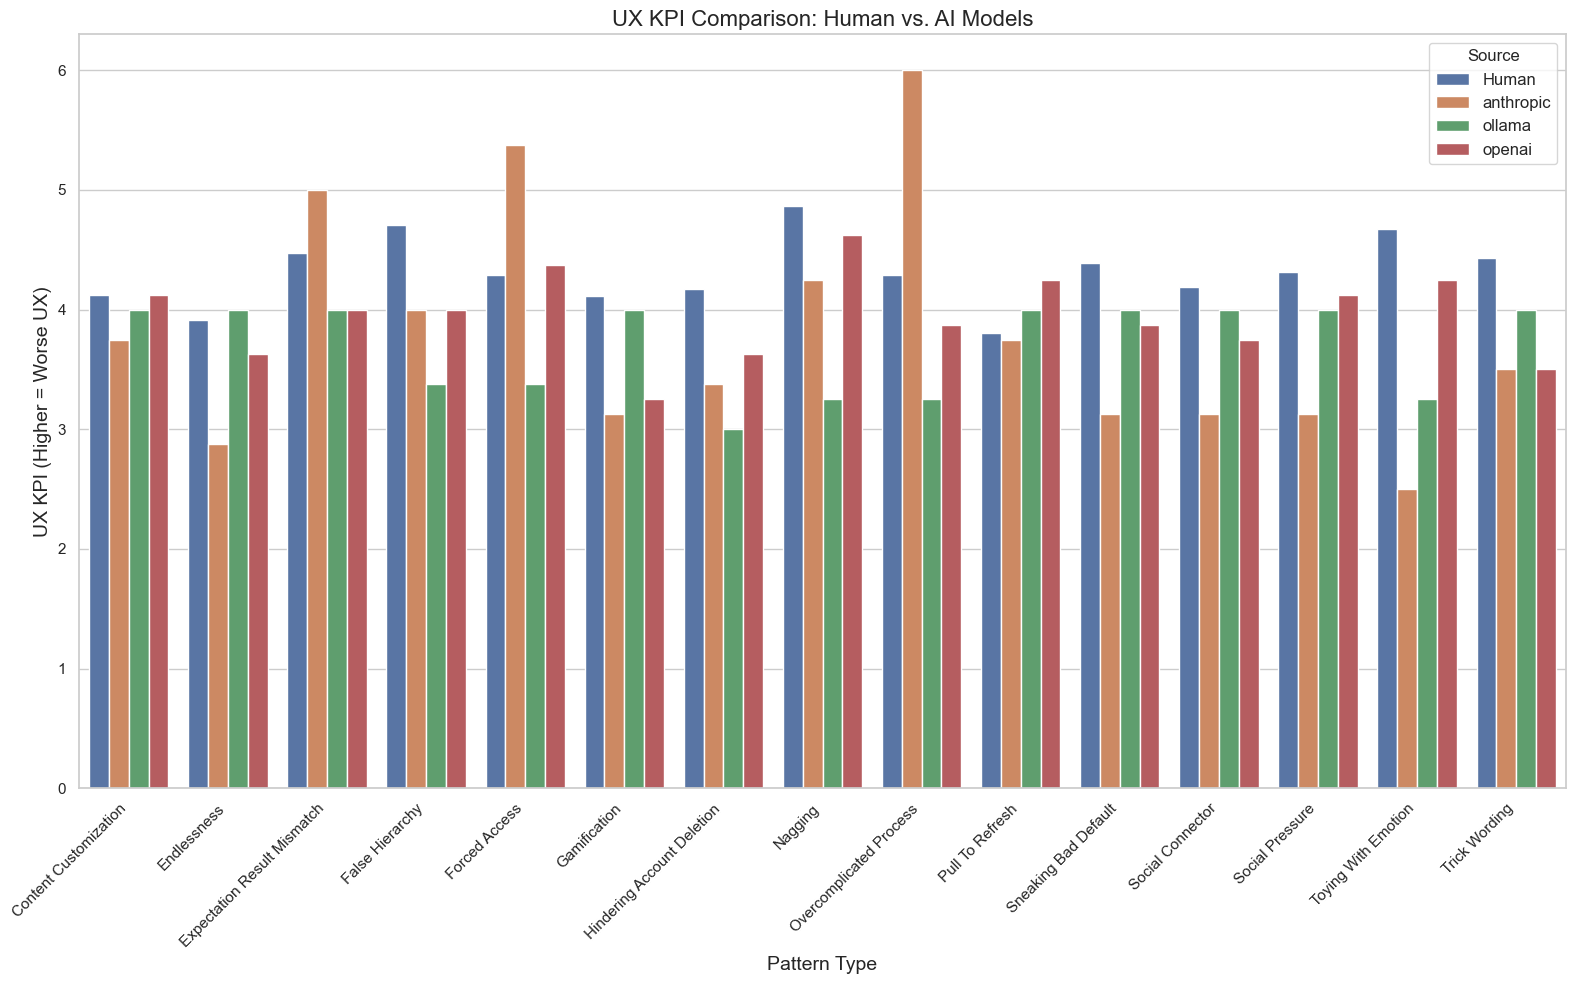

In [6]:
# Prepare data for visualization
# Create a long-format dataframe for easier plotting
comparison_data = []

# Add human data
for idx, row in human_pattern_kpi.iterrows():
    pattern = row['metadata_pattern_type']
    comparison_data.append({
        'pattern_type': pattern,
        'source': 'Human',
        'model': 'Human',
        'ux_kpi': row['human_ux_kpi']
    })

# Add model data
for service in model_data_with_kpi['metadata_ai_service'].unique():
    for model in model_data_with_kpi[model_data_with_kpi['metadata_ai_service'] == service]['metadata_model'].unique():
        # Get model UX KPI for each pattern
        filter_mask = (model_pattern_kpi['metadata_ai_service'] == service) & (model_pattern_kpi['metadata_model'] == model)
        model_patterns = model_pattern_kpi[filter_mask]
        
        for idx, row in model_patterns.iterrows():
            pattern = row['metadata_pattern_type']
            comparison_data.append({
                'pattern_type': pattern,
                'source': service,
                'model': model,
                'ux_kpi': row['ux_kpi']
            })

comparison_df = pd.DataFrame(comparison_data)

# Fix the "Pull to Refresh" and "Pull To Refresh" inconsistency
comparison_df['pattern_type'] = comparison_df['pattern_type'].replace('Pull to Refresh', 'Pull To Refresh')

# Create bar chart
plt.figure(figsize=(16, 10))
ax = sns.barplot(x='pattern_type', y='ux_kpi', hue='source', data=comparison_df)

# Customize chart
plt.title('UX KPI Comparison: Human vs. AI Models', fontsize=16)
plt.xlabel('Pattern Type', fontsize=14)
plt.ylabel('UX KPI (Higher = Worse UX)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Source', fontsize=12)
plt.tight_layout()

# Save figure
plt.savefig(os.path.join(output_dir, 'human_model_ux_kpi_comparison.png'))
plt.show()

## Create Gauge Visualizations

Now let's create gauge visualizations for both human and model assessments.

In [7]:
# Calculate UX metrics by pattern for human data
human_pattern_avg = human_data_with_kpi.groupby('metadata_pattern_type').agg({
    'ux_kpi': 'mean',
    'worst_aspect': lambda x: x.mode()[0] if not x.mode().empty else None,
    'worst_value': 'mean'
}).reset_index()

# Save human pattern metrics to CSV 
human_metrics_path = os.path.join(output_dir, 'human_pattern_metrics.csv')
human_pattern_avg.to_csv(human_metrics_path, index=False)
print(f"Human pattern metrics saved to {human_metrics_path}")

Human pattern metrics saved to comparison_output/human_pattern_metrics.csv


In [8]:
# Create gauge visualizations for model assessments (one per model for each pattern)
for service in model_data_with_kpi['metadata_ai_service'].unique():
    for model in model_data_with_kpi[model_data_with_kpi['metadata_ai_service'] == service]['metadata_model'].unique():
        # Create directory for this model
        model_gauges_dir = os.path.join(output_dir, f"{service}_{model}_gauges")
        os.makedirs(model_gauges_dir, exist_ok=True)
        
        # Filter data for this model
        model_filter = (model_data_with_kpi['metadata_ai_service'] == service) & \
                       (model_data_with_kpi['metadata_model'] == model)
        this_model_data = model_data_with_kpi[model_filter]
        
        # Calculate UX metrics by pattern
        model_pattern_metrics = {}
        ux_items = [col for col in this_model_data.columns if col.startswith('ux_') and col != 'ux_kpi']
        
        for pattern, group in this_model_data.groupby('metadata_pattern_type'):
            # Calculate mean for each UX item
            item_means = group[ux_items].mean()
            
            # Skip if we have no data
            if item_means.isnull().all():
                continue
                
            # Find the worst item (highest value is worst since we're measuring negative aspects)
            worst_item = item_means.idxmax()
            worst_value = item_means[worst_item]
            
            # Calculate UX KPI from the means (not mean of UX KPI)
            ux_kpi = item_means.mean()
            
            model_pattern_metrics[pattern] = {
                'worst_aspect': worst_item.replace('ux_', ''),
                'worst_value': worst_value,
                'ux_kpi': ux_kpi
            }
        
        # Create gauge for each pattern type
        for pattern, metrics in model_pattern_metrics.items():
            worst_aspect = metrics['worst_aspect']
            worst_value = metrics['worst_value']
            ux_kpi = metrics['ux_kpi']
            
            # Skip if any values are NaN
            if pd.isna(pattern) or pd.isna(worst_aspect) or pd.isna(worst_value) or pd.isna(ux_kpi):
                continue
            
            # Determine color based on worst_value
            if worst_value > 5:
                text_color = "lightcoral"
            elif worst_value > 3:
                text_color = "orange"
            else:
                text_color = "lightgreen"
            
            # Create gauge visualization
            fig = go.Figure(go.Indicator(
                mode="gauge+number+delta",
                value=worst_value,
                domain={'x': [0, 1], 'y': [0, 0.9]},
                delta={
                    'reference': ux_kpi,
                    'font': {'size': 1},
                    'position': "bottom",
                    'relative': False,
                    'increasing': {'symbol': " "},
                    'decreasing': {'symbol': " ", 'color': "white"},
                    'valueformat': " "
                },
                title={
                    'text': f"<span style='font-size:1em;color:gray'>{pattern} ({service} {model})</span><br>" +
                           f"<span style='font-size:1em;color:black'>UX KPI: {ux_kpi:.2f}</span>",
                    'font': {'size': 24}
                },
                number={
                    'font': {'size': 80, 'color': text_color},
                    'suffix': f"<br><b><span style='font-size:1.0em;color:{text_color}'>{worst_aspect}</span>",
                },
                gauge={
                    'axis': {'range': [1, 7]},
                    'bar': {'color': "green" if worst_value < 3 else "orange" if worst_value < 5 else "red"},
                    'steps': [
                        {'range': [1, 3], 'color': "lightgreen"},
                        {'range': [3, 5], 'color': "lightyellow"},
                        {'range': [5, 7], 'color': "lightcoral"}
                    ],
                    'threshold': {
                        'line': {'color': "black", 'width': 4},
                        'thickness': 0.75,
                        'value': ux_kpi
                    }
                }
            ))
            
            fig.update_layout(
                margin=dict(l=20, r=20, t=50, b=100),
                height=600
            )
            
            # Save gauge visualization
            file_path = os.path.join(model_gauges_dir, f"{pattern.replace(' ', '_')}.png")
            fig.write_image(file_path)

## Analyze Worst Aspects

Compare which aspects were rated as worst by humans vs. models for each pattern.

In [9]:
# Create a comparison table of worst aspects
worst_aspect_comparison = human_pattern_avg[['metadata_pattern_type', 'worst_aspect']].rename(
    columns={'worst_aspect': 'human_worst_aspect'}
)

# Fix the "Pull to Refresh" and "Pull To Refresh" inconsistency
worst_aspect_comparison['metadata_pattern_type'] = worst_aspect_comparison['metadata_pattern_type'].replace('Pull to Refresh', 'Pull To Refresh')

# Add model worst aspects
for service in model_data_with_kpi['metadata_ai_service'].unique():
    for model in model_data_with_kpi[model_data_with_kpi['metadata_ai_service'] == service]['metadata_model'].unique():
        model_filter = (model_data_with_kpi['metadata_ai_service'] == service) & \
                       (model_data_with_kpi['metadata_model'] == model)
        this_model_data = model_data_with_kpi[model_filter]
        
        # Normalize pattern names
        this_model_data['metadata_pattern_type'] = this_model_data['metadata_pattern_type'].replace('Pull to Refresh', 'Pull To Refresh')
        
        # Calculate most common worst aspect for each pattern type
        model_worst_aspects = this_model_data.groupby('metadata_pattern_type')['worst_aspect'].agg(
            lambda x: x.mode()[0] if not x.mode().empty else None
        ).reset_index()
        
        model_worst_aspects = model_worst_aspects.rename(
            columns={'worst_aspect': f'{service}_{model}_worst_aspect'}
        )
        
        # Add to comparison table
        worst_aspect_comparison = worst_aspect_comparison.merge(
            model_worst_aspects, on='metadata_pattern_type', how='outer'
        )

# Remove duplicate rows for Pull To Refresh
worst_aspect_comparison = worst_aspect_comparison.drop_duplicates(subset=['metadata_pattern_type'])

# Display comparison table
print("Comparison of Worst UX Aspects:")
worst_aspect_comparison

Comparison of Worst UX Aspects:


/var/folders/66/73cb2jcd6jg68q_rlbh1rhzw0000gp/T/ipykernel_91692/1272727393.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/66/73cb2jcd6jg68q_rlbh1rhzw0000gp/T/ipykernel_91692/1272727393.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/66/73cb2jcd6jg68q_rlbh1rhzw0000gp/T/ipykernel_91692/1272727393.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

,metadata_pattern_type,human_worst_aspect,anthropic_claude-3-opus-20240229_worst_aspect,ollama_gemma3_worst_aspect,openai_gpt-4-turbo_worst_aspect
0,Content Customization,boring,boring,not_interesting,confusing
1,Endlessness,cluttered,obstructive,not_interesting,not_interesting
2,Expectation Result Mismatch,boring,boring,not_interesting,boring
3,False Hierarchy,boring,inefficient,boring,boring
4,Forced Access,confusing,boring,boring,not_interesting
5,Gamification,complicated,boring,not_interesting,complicated
6,Hindering Account Deletion,boring,not_interesting,boring,boring
7,Nagging,boring,obstructive,boring,complicated
8,Overcomplicated Process,complicated,cluttered,boring,boring
9,Pull To Refresh,cluttered,unpredictable,not_interesting,unpredictable


## Analyze Agreement Between Humans and Models

Calculate how closely models' assessments align with human assessments.

In [10]:
# Import necessary libraries for reliability analysis
from sklearn.metrics import cohen_kappa_score

# Function to calculate inter-annotator agreement within a group
def calculate_within_group_agreement(df, group_col, pattern_col, metric_cols):
    """Calculate agreement metrics within a group (humans or specific AI model)"""
    agreement_results = {}
    
    # Group by pattern type
    patterns = df[pattern_col].unique()
    participants = df[group_col].unique()
    
    if len(participants) < 2:
        return {"error": "Need at least 2 participants for agreement calculations"}
    
    # For each metric
    for metric in metric_cols:
        # Create a matrix of ratings: rows=patterns, columns=participants
        ratings_matrix = []
        
        for pattern in patterns:
            pattern_ratings = []
            for participant in participants:
                # Get this participant's rating for this pattern
                mask = (df[pattern_col] == pattern) & (df[group_col] == participant)
                
                # If multiple ratings exist, take the mean
                ratings = df.loc[mask, metric].mean() if sum(mask) > 0 else None
                pattern_ratings.append(ratings)
            
            ratings_matrix.append(pattern_ratings)
        
        # Convert to numeric categories for kappa calculation (1-7 scale to 0-2 categories)
        categorized_matrix = []
        for pattern_ratings in ratings_matrix:
            categorized_ratings = []
            for rating in pattern_ratings:
                if pd.isna(rating):
                    categorized_ratings.append(None)
                elif rating <= 3:
                    categorized_ratings.append(0)  # Low
                elif rating <= 5:
                    categorized_ratings.append(1)  # Medium
                else:
                    categorized_ratings.append(2)  # High
            categorized_matrix.append(categorized_ratings)
        
        # Calculate pairwise Cohen's kappa
        kappa_values = []
        
        for i in range(len(participants)):
            for j in range(i+1, len(participants)):
                # Extract ratings for these two participants
                ratings_i = []
                ratings_j = []
                
                for pattern_idx in range(len(patterns)):
                    if (categorized_matrix[pattern_idx][i] is not None and 
                        categorized_matrix[pattern_idx][j] is not None):
                        ratings_i.append(categorized_matrix[pattern_idx][i])
                        ratings_j.append(categorized_matrix[pattern_idx][j])
                
                # Calculate kappa if we have enough data
                if len(ratings_i) >= 2:
                    try:
                        kappa = cohen_kappa_score(ratings_i, ratings_j)
                        kappa_values.append(kappa)
                    except Exception as e:
                        print(f"Error calculating kappa: {e}")
        
        # Store results
        if kappa_values:
            agreement_results[metric] = {
                'mean_kappa': sum(kappa_values) / len(kappa_values),
                'min_kappa': min(kappa_values),
                'max_kappa': max(kappa_values),
                'num_pairs': len(kappa_values)
            }
    
    return agreement_results

# Calculate agreement within humans
print("Calculating inter-annotator agreement within humans...")
human_agreement = calculate_within_group_agreement(
    human_data_with_kpi, 
    'metadata_participant_id', 
    'metadata_pattern_type', 
    [col for col in human_data_with_kpi.columns if col.startswith('score_')]
)

print("Human inter-annotator agreement:")
for metric, values in human_agreement.items():
    if isinstance(values, dict) and 'mean_kappa' in values:
        print(f"{metric}: Mean κ = {values['mean_kappa']:.2f} (min: {values['min_kappa']:.2f}, max: {values['max_kappa']:.2f})")

# Calculate agreement within each model
model_agreement = {}

for service in model_data_with_kpi['metadata_ai_service'].unique():
    for model in model_data_with_kpi[model_data_with_kpi['metadata_ai_service'] == service]['metadata_model'].unique():
        # Filter to just this model's data
        model_filter = (model_data_with_kpi['metadata_ai_service'] == service) & \
                      (model_data_with_kpi['metadata_model'] == model)
        this_model_data = model_data_with_kpi[model_filter]
        
        # Check if we have multiple runs/participants
        if len(this_model_data['metadata_timestamp'].unique()) > 1:
            print(f"\nCalculating agreement within {service} {model}...")
            # Use timestamp as the participant ID if no participant ID column
            participant_col = 'metadata_participant_id' if 'metadata_participant_id' in this_model_data.columns else 'metadata_timestamp'
            
            model_agreement[f"{service}_{model}"] = calculate_within_group_agreement(
                this_model_data,
                participant_col,
                'metadata_pattern_type',
                [col for col in this_model_data.columns if col.startswith('score_')]
            )
            
            print(f"{service} {model} agreement:")
            for metric, values in model_agreement[f"{service}_{model}"].items():
                if isinstance(values, dict) and 'mean_kappa' in values:
                    print(f"{metric}: Mean κ = {values['mean_kappa']:.2f} (min: {values['min_kappa']:.2f}, max: {values['max_kappa']:.2f})")
        else:
            print(f"\nSkipping {service} {model} - not enough runs for agreement calculation")

# Calculate agreement between humans and each model
human_model_agreement = {}

for service in model_data_with_kpi['metadata_ai_service'].unique():
    for model in model_data_with_kpi[model_data_with_kpi['metadata_ai_service'] == service]['metadata_model'].unique():
        # Filter to just this model's data
        model_filter = (model_data_with_kpi['metadata_ai_service'] == service) & \
                      (model_data_with_kpi['metadata_model'] == model)
        this_model_data = model_data_with_kpi[model_filter]
        
        # Calculate average scores for each pattern
        model_avg = this_model_data.groupby('metadata_pattern_type').mean()
        human_avg = human_data_with_kpi.groupby('metadata_pattern_type').mean()
        
        # Find patterns in common
        common_patterns = set(model_avg.index) & set(human_avg.index)
        
        if len(common_patterns) >= 2:
            print(f"\nCalculating agreement between humans and {service} {model}...")
            
            # Calculate agreement for each metric
            agreement_results = {}
            
            for metric in [col for col in model_avg.columns if col.startswith('score_')]:
                if metric in human_avg.columns:
                    try:
                        # Get ratings for common patterns
                        model_ratings = []
                        human_ratings = []
                        
                        for pattern in common_patterns:
                            if not pd.isna(model_avg.loc[pattern, metric]) and not pd.isna(human_avg.loc[pattern, metric]):
                                # Categorize ratings
                                model_cat = 0 if model_avg.loc[pattern, metric] <= 3 else 1 if model_avg.loc[pattern, metric] <= 5 else 2
                                human_cat = 0 if human_avg.loc[pattern, metric] <= 3 else 1 if human_avg.loc[pattern, metric] <= 5 else 2
                                
                                model_ratings.append(model_cat)
                                human_ratings.append(human_cat)
                        
                        # Calculate kappa if we have enough data
                        if len(model_ratings) >= 2:
                            kappa = cohen_kappa_score(model_ratings, human_ratings)
                            agreement_results[metric] = kappa
                    except Exception as e:
                        print(f"Error calculating {metric} agreement: {e}")
            
            human_model_agreement[f"{service}_{model}"] = agreement_results
            
            print(f"Human-{service} {model} agreement:")
            for metric, kappa in agreement_results.items():
                print(f"{metric}: κ = {kappa:.2f}")
        else:
            print(f"\nSkipping human-{service} {model} agreement - not enough common patterns")

# Save all agreement results
agreement_summary = {
    "within_human": human_agreement,
    "within_model": model_agreement,
    "human_model": human_model_agreement
}

import json
with open(os.path.join(output_dir, 'inter_annotator_agreement.json'), 'w') as f:
    json.dump(agreement_summary, f, indent=2, default=str)
print(f"\nAgreement results saved to {os.path.join(output_dir, 'inter_annotator_agreement.json')}")

/Users/hgs52/Documents/Github/AI-UI-Ethics-Evaluations/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:407: UserWarning:

A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.

/Users/hgs52/Documents/Github/AI-UI-Ethics-Evaluations/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:758: RuntimeWarning:

invalid value encountered in scalar divide

/Users/hgs52/Documents/Github/AI-UI-Ethics-Evaluations/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:407: UserWarning:

A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.

/Users/hgs52/Documents/Github/AI-UI-Ethics-Evaluations/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:758: RuntimeWarning:

invalid value encountered in scalar divide

/Users/hgs52/Documen

Calculating inter-annotator agreement within humans...


/Users/hgs52/Documents/Github/AI-UI-Ethics-Evaluations/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:407: UserWarning:

A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.

/Users/hgs52/Documents/Github/AI-UI-Ethics-Evaluations/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:758: RuntimeWarning:

invalid value encountered in scalar divide

/Users/hgs52/Documents/Github/AI-UI-Ethics-Evaluations/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:407: UserWarning:

A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.

/Users/hgs52/Documents/Github/AI-UI-Ethics-Evaluations/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:758: RuntimeWarning:

invalid value encountered in scalar divide

/Users/hgs52/Documen

Human inter-annotator agreement:
score_inefficient_efficient: Mean κ = nan (min: -1.00, max: 1.00)
score_interesting_not_interesting: Mean κ = nan (min: -1.00, max: 1.00)
score_clear_confusing: Mean κ = nan (min: -1.00, max: 1.00)
score_enjoyable_annoying: Mean κ = nan (min: -1.00, max: 1.00)
score_organized_cluttered: Mean κ = nan (min: -1.00, max: 1.00)
score_addictive_non_addictive: Mean κ = nan (min: -1.00, max: 1.00)
score_supportive_obstructive: Mean κ = nan (min: -1.00, max: 1.00)
score_pressuring_suggesting: Mean κ = nan (min: -1.00, max: 1.00)
score_boring_exciting: Mean κ = nan (min: -1.00, max: 1.00)
score_revealed_covert: Mean κ = nan (min: -1.00, max: 1.00)
score_complicated_easy: Mean κ = nan (min: -1.00, max: 1.00)
score_unpredictable_predictable: Mean κ = nan (min: -1.00, max: 1.00)
score_friendly_unfriendly: Mean κ = nan (min: -1.00, max: 1.00)
score_deceptive_benevolent: Mean κ = nan (min: -1.00, max: 1.00)

Calculating agreement within anthropic claude-3-opus-2024022

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

## Create Summary Table of UX KPI By Pattern

Create a clean, easy-to-read table of UX KPI scores for each pattern, comparing humans and models.

In [ ]:
# Create a clean summary table
summary_table = pd.DataFrame({
    'Pattern Type': human_pattern_avg['metadata_pattern_type'],
    'Human UX KPI': human_pattern_avg['ux_kpi'],
    'Human Worst Aspect': human_pattern_avg['worst_aspect']
})

# Fix the "Pull to Refresh" and "Pull To Refresh" inconsistency
summary_table['Pattern Type'] = summary_table['Pattern Type'].replace('Pull to Refresh', 'Pull To Refresh')

# Add model data
for service in model_data_with_kpi['metadata_ai_service'].unique():
    for model in model_data_with_kpi[model_data_with_kpi['metadata_ai_service'] == service]['metadata_model'].unique():
        if pd.isna(model):
            continue
            
        model_filter = (model_data_with_kpi['metadata_ai_service'] == service) & \
                      (model_data_with_kpi['metadata_model'] == model)
        this_model_data = model_data_with_kpi[model_filter]
        
        # Normalize pattern names
        this_model_data['metadata_pattern_type'] = this_model_data['metadata_pattern_type'].replace('Pull to Refresh', 'Pull To Refresh')
        
        model_pattern_avg = this_model_data.groupby('metadata_pattern_type').agg({
            'ux_kpi': 'mean',
            'worst_aspect': lambda x: x.mode()[0] if not x.mode().empty else None
        }).reset_index()
        
        # Skip if empty
        if len(model_pattern_avg) == 0:
            continue
            
        # Create a temporary dataframe
        temp_df = pd.DataFrame({
            'Pattern Type': model_pattern_avg['metadata_pattern_type'],
            f'{service} {model} UX KPI': model_pattern_avg['ux_kpi'],
            f'{service} {model} Worst Aspect': model_pattern_avg['worst_aspect']
        })
        
        # Merge with summary table
        summary_table = summary_table.merge(temp_df, on='Pattern Type', how='outer')

# Remove duplicate rows for Pull To Refresh
summary_table = summary_table.drop_duplicates(subset=['Pattern Type'])

# Sort by Human UX KPI (worst to best)
summary_table = summary_table.sort_values('Human UX KPI', ascending=False)

# Display summary table
print("UX KPI Summary by Pattern Type:")
summary_table

# Save summary table to CSV
summary_path = os.path.join(output_dir, 'ux_kpi_summary.csv')
summary_table.to_csv(summary_path, index=False)
print(f"Summary saved to {summary_path}")

## Conclusion

This notebook has provided:
1. A clear comparison of UX KPI metrics between human and model assessments
2. Gauge visualizations for each pattern type showing worst aspects
3. Analysis of agreement between humans and different AI models
4. Summary tables that can be easily referenced for presentations or papers